In [1]:
from datetime import datetime
import yfinance as yf
from dateutil.relativedelta import relativedelta
import calendar
import joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
symbol = 'VALE'
start_date = '2018-01-01'
end_date = '2025-06-30'

df = yf.download(symbol, start=start_date, end=end_date)

/var/folders/9l/ssjsy50d6vqb5mscfhwxj6h80000gp/T/ipykernel_75687/2965056343.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,VALE,VALE,VALE,VALE,VALE
Date,,,,,
2018-01-02,7.465320,7.482857,7.313324,7.336708,19189400
2018-01-03,7.512088,7.523780,7.412707,7.482858,20449600
2018-01-04,7.500396,7.652392,7.494550,7.617316,22033100
2018-01-05,7.652393,7.652393,7.441937,7.482859,20042800
2018-01-08,7.786850,7.786850,7.705007,7.751774,17507000
...,...,...,...,...,...
2025-06-23,9.180000,9.190000,9.010000,9.050000,38963300
2025-06-24,9.210000,9.210000,9.120000,9.180000,34861500


In [5]:
# Converte strings para objetos datetime
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')

# Calcula o número total de meses
total_months = (end.year - start.year) * 12 + (end.month - start.month)

print(f'Total de meses entre as datas: {total_months}')

Total de meses entre as datas: 89


In [6]:
total_meses_trunc = int(round(total_months * 0.7,0))

In [7]:
total_meses_trunc

62

In [8]:
#from datetime import datetime
#
#

#start_date = '2018-01-01'

# Converte string para objeto datetime
start = datetime.strptime(start_date, '%Y-%m-%d')

# Adiciona 62 meses
new_date = start + relativedelta(months=+62)

# Ajusta para o último dia do mês
last_day = calendar.monthrange(new_date.year, new_date.month)[1]
final_date = new_date.replace(day=last_day)

# Exibe o resultado formatado
print('Nova data (último dia do mês):', final_date.strftime('%Y-%m-%d'))


Nova data (último dia do mês): 2023-03-31


In [9]:
new_date

datetime.datetime(2023, 3, 1, 0, 0)

In [10]:
final_date

datetime.datetime(2023, 3, 31, 0, 0)

In [11]:
# Separa treino e teste
df_train = df[df.index <= final_date]
df_test = df[df.index > final_date]

In [12]:
df_train.shape

(1321, 5)

In [13]:
df_test

Price,Close,High,Low,Open,Volume
Ticker,VALE,VALE,VALE,VALE,VALE
Date,,,,,
2023-04-03,13.038064,13.079455,12.947005,12.980117,12833500
2023-04-04,12.624157,12.980117,12.615879,12.947005,26787600
2023-04-05,12.566211,12.657270,12.417204,12.624157,32733900
2023-04-06,12.499987,12.557933,12.400648,12.533099,15408600
2023-04-10,12.723495,12.748330,12.591045,12.615880,11192900
...,...,...,...,...,...
2025-06-23,9.180000,9.190000,9.010000,9.050000,38963300
2025-06-24,9.210000,9.210000,9.120000,9.180000,34861500


In [14]:
# Seleciona apenas a coluna de fechamento
target_col = 'Close'

# Escala os dados entre 0 e 1
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train[[target_col]])
df_test_scaled = scaler.transform(df_test[[target_col]])
joblib.dump(scaler, "app/models/scaler.joblib")
# Parâmetros
n_past = 60  # janela: quantos dias anteriores usar
n_future =30  # quantos dias à frente queremos prever


In [15]:
def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, 0])
        y.append(data[i + n_future - 1:i + n_future, 0])
    return np.array(X), np.array(y)


In [16]:
X_train, y_train = create_sequences(df_train_scaled, n_past, n_future)
X_test, y_test = create_sequences(df_test_scaled, n_past, n_future)

# LSTM espera 3D (amostras, passos de tempo, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [17]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_past, 1)))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20


/opt/miniconda3/envs/tc_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1899 - val_loss: 0.1600
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0359 - val_loss: 0.0300
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0215 - val_loss: 0.0175
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0157 - val_loss: 0.0122
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - val_loss: 0.0165
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - val_loss: 0.0181
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0136 - val_loss: 0.0077
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - val_loss: 0.0081
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0115 - val_loss: 0.0203
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 - val_loss: 0.0061


In [18]:
# Previsões (em escala normalizada)
y_pred_scaled = model.predict(X_test)

# Retorna para escala original
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Pega apenas o último valor previsto (x dias à frente) de cada janela
y_pred_final = y_pred[:, -1]
y_true_final = y_true[:, -1]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [19]:
mae = mean_absolute_error(y_true_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mape = mean_absolute_percentage_error(y_true_final, y_pred_final) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


MAE: 1.16
RMSE: 1.37
MAPE: 11.50%


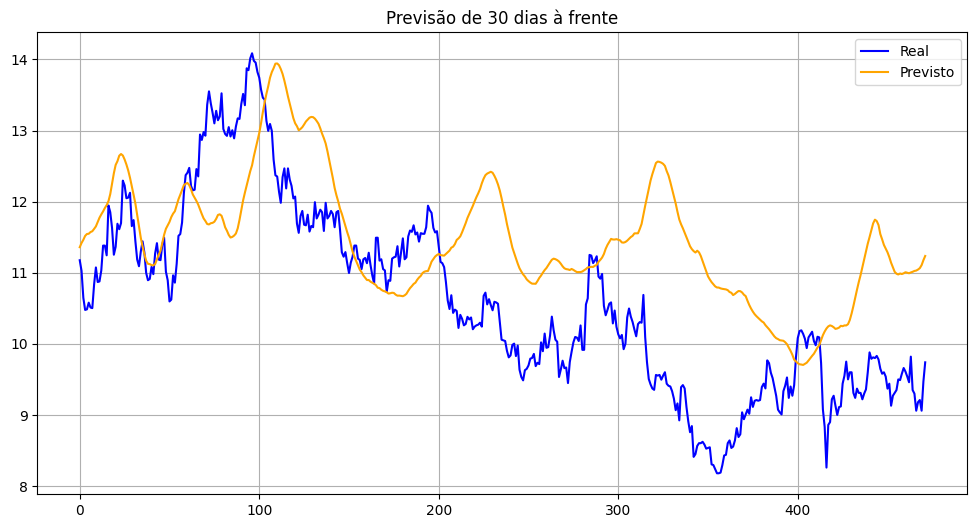

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_true_final, label='Real', color='blue')
plt.plot(y_pred_final, label='Previsto', color='orange')
plt.title(f'Previsão de {n_future} dias à frente')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Últimos n_past dias antes de final_date
last_window = df_train[[target_col]].iloc[-n_past:].values
last_window_scaled = scaler.transform(last_window)

# Formatar para input da LSTM: (1, n_past, 1)
X_input = last_window_scaled.reshape((1, n_past, 1))


In [22]:
n_days_ahead = 30  # por exemplo, x = 5

# Começa com a janela de entrada atual
input_seq = last_window_scaled.copy().reshape((1, n_past, 1))

predictions_scaled = []

for _ in range(n_days_ahead):
    pred = model.predict(input_seq)[0][-1]  # pega último output
    predictions_scaled.append(pred)

    # Atualiza a janela com o novo valor previsto
    new_input = np.append(input_seq[0, 1:, 0], pred)  # remove primeiro, adiciona o novo
    input_seq = new_input.reshape((1, n_past, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [29]:
# Transforma array e reescala
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions_scaled)
print(predictions_scaled)
print(predictions)
# Resultado final
for i, val in enumerate(predictions):
    print(f"Previsão para o dia {i+1} após {final_date}: {val[0]:.2f}")


[[0.5509609 ]
 [0.5384507 ]
 [0.5277057 ]
 [0.51763785]
 [0.5087518 ]
 [0.50066644]
 [0.493006  ]
 [0.48570198]
 [0.4790824 ]
 [0.47284836]
 [0.46635586]
 [0.4597531 ]
 [0.4535873 ]
 [0.44796956]
 [0.44253027]
 [0.43776935]
 [0.43330103]
 [0.4290349 ]
 [0.42488545]
 [0.42076832]
 [0.416533  ]
 [0.41273057]
 [0.40938127]
 [0.4069752 ]
 [0.40525508]
 [0.40383375]
 [0.40243065]
 [0.40124333]
 [0.4007628 ]
 [0.40101612]]
[[10.819351 ]
 [10.666991 ]
 [10.536129 ]
 [10.413513 ]
 [10.305291 ]
 [10.2068205]
 [10.113525 ]
 [10.02457  ]
 [ 9.943952 ]
 [ 9.868028 ]
 [ 9.788957 ]
 [ 9.708542 ]
 [ 9.63345  ]
 [ 9.565032 ]
 [ 9.498788 ]
 [ 9.4408045]
 [ 9.386386 ]
 [ 9.334429 ]
 [ 9.283894 ]
 [ 9.233751 ]
 [ 9.18217  ]
 [ 9.13586  ]
 [ 9.09507  ]
 [ 9.065766 ]
 [ 9.044818 ]
 [ 9.027507 ]
 [ 9.010419 ]
 [ 8.995959 ]
 [ 8.990107 ]
 [ 8.993192 ]]
Previsão para o dia 1 após 2023-03-31 00:00:00: 10.82
Previsão para o dia 2 após 2023-03-31 00:00:00: 10.67
Previsão para o dia 3 após 2023-03-31 00:00:00: 10

In [24]:
x = 30

In [25]:
# Exemplo: suponha que você tem os preços reais em df_test
real_values = df_test[[target_col]].iloc[:x].values  # x primeiros dias do futuro
real_values = real_values[:len(predictions)]

# Avaliação
mae = mean_absolute_error(real_values, predictions)
rmse = np.sqrt(mean_squared_error(real_values, predictions))
mape = mean_absolute_percentage_error(real_values, predictions) * 100

print(f'MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%')


MAE: 2.53 | RMSE: 2.56 | MAPE: 20.76%


In [26]:
real_values

array([[13.038064  ],
       [12.62415695],
       [12.56621075],
       [12.49998665],
       [12.72349548],
       [13.59269905],
       [13.44369221],
       [13.28640747],
       [13.21190548],
       [12.98011971],
       [13.0546217 ],
       [12.39237022],
       [12.18541622],
       [11.8129015 ],
       [11.70528507],
       [11.3907156 ],
       [11.49833202],
       [11.8625679 ],
       [11.92879391],
       [11.75495338],
       [11.39899349],
       [11.41555023],
       [11.05959034],
       [11.50660801],
       [11.50660801],
       [11.67217255],
       [11.58939075],
       [11.34932518],
       [11.40727043],
       [11.65561485]])

In [27]:
predictions

array([[10.819351 ],
       [10.666991 ],
       [10.536129 ],
       [10.413513 ],
       [10.305291 ],
       [10.2068205],
       [10.113525 ],
       [10.02457  ],
       [ 9.943952 ],
       [ 9.868028 ],
       [ 9.788957 ],
       [ 9.708542 ],
       [ 9.63345  ],
       [ 9.565032 ],
       [ 9.498788 ],
       [ 9.4408045],
       [ 9.386386 ],
       [ 9.334429 ],
       [ 9.283894 ],
       [ 9.233751 ],
       [ 9.18217  ],
       [ 9.13586  ],
       [ 9.09507  ],
       [ 9.065766 ],
       [ 9.044818 ],
       [ 9.027507 ],
       [ 9.010419 ],
       [ 8.995959 ],
       [ 8.990107 ],
       [ 8.993192 ]], dtype=float32)

In [28]:
model.save(f'app/models/general_lstm.h5')
